In [1]:
import requests
import pandas as pd
import json 
import time
import requests_cache
import lxml.html
import re
from lxml.etree import tostring
from bs4 import BeautifulSoup
import numpy as np
import math
import folium
import matplotlib.pyplot as plt
from IPython.display import display
requests_cache.install_cache("mycache")


Apartments.com has easily retrievable phone numbers
Zillow offers coordinates

In [2]:
#Querying Apartments.com

aparesponse = requests.post("https://www.apartments.com/services/search/", 
                           headers = {
                               "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36",
                               "x-requested-with": "XMLHttpRequest"},
                           json = {"Map":
                                   {"BoundingBox": 
                                    {"UpperLeft":
                                     {"Latitude": 47.137567392512295,
                                      "Longitude": -123.00609617698669},
                                     "LowerRight":
                                     {"Latitude": 46.94243656145295,
                                      "Longitude": -122.73006468284606}},
                                    "CountryCode": "US"},
                                   "Geography":
                                    {"GeographyType":7,
                                     "Address":{"CountryCode":"US"},
                                     "Location":{"Latitude": 47.037, 
                                                 "Longitude": -122.865}},
                                   "Listing":{"MinBeds": 1, 
                                       "MaxBeds": 2, 
                                       "PetFriendly": 2, 
                                       "Style": 1,
                                       "Amenities": 66048, #Pool, Cat Friendly, and has Business Center
                                              #To find just Pool, Cat Friendly, use 512
                                              #To find Pool, Cat Friendly, and has Business Center, use 536871424
                                              #To find Pool, Cat Friendly, and has Parking, use 66048
                                              #To find Pool, Cat Friendly, Parking, and Business Center, use 536936960
                                       "MaxRentAmount": 2100},
                                   #"Paging":{"Page":None},
                                   #"ResultSeed":587836,
                                   #"Options":0,
                                   "CountryAbbreviation":"US",
                                   "IsBoundedSearch":None})

# aparesults = json.loads(aparesponse.text.replace("\'", "\""))
# aparesults = pd.DataFrame([x["cell"] for x in aparesults["rows"]])
aparesponse


<Response [200]>

In [3]:
aparesults = aparesponse.json()
apahtmlres = aparesults["PlacardState"]["HTML"] 
#json output returns a dict where an HTML output exists within the key "PlacardState"
print(aparesults.keys())
print(aparesults["PlacardState"].keys())

dict_keys(['ResultKey', 'MetaState', 'UrlState', 'PinsState', 'PlacardState', 'SearchCriteria', 'EncodedBoundingBox', 'bs', 'ffs', 'RemoveOutlineText', 'abd', 'Magicbar', 'FAQs', 'SearchPriceMinimums', 'SearchPriceMaximums', 'H1HeaderSRPText'])
dict_keys(['HTML', 'TotalExtendedListings'])


In [4]:
apahtmlres[1:1000] #demonstrating HTML extract

'\n<div id="placardContainer" class="placardContainer" data-analytics-profiletype="Unknown">\r\n    <ul>\r\n\r\n<li class="mortar-wrapper">\r\n    <article class="placard placard-option-diamond has-header js-diamond" data-listingid="qnpjn4y" data-url="https://www.apartments.com/smyth-olympia-wa/qnpjn4y/" data-streetaddress="3425 Polo Club Ln SE" data-countrycode="US" data-ck="dv0gtnl">\r\n        <header class="placard-header has-logo">\r\n            <div class="property-information">\r\n                <a class="property-link" href="https://www.apartments.com/smyth-olympia-wa/qnpjn4y/" aria-label="Smyth, Olympia, WA">\r\n                    \r\n                    <div class="property-title" title="Smyth, Olympia, WA"><span class="js-placardTitle title">Smyth</span></div>\r\n                    <div class="property-address js-url" title="3425 Polo Club Ln SE, Olympia, WA 98501">3425 Polo Club Ln SE, Olympia, WA 98501</div>\r\n                </a>\r\n            </div>\r\n            

In [5]:
parsedapa = BeautifulSoup(apahtmlres) #parse the HTML output
htmlnames = parsedapa.find_all('span', attrs = {'class':"js-placardTitle title"})#[1].contents
names = htmlnames[:]
names = [i.string.strip() for i in names]
#names


In [6]:
htmladds = parsedapa.find_all('div', attrs = {'class':"property-address js-url"})
adds = htmladds[:]
adds = [i.string.strip() for i in adds]
#finds and parses addresses, decomposes into smaller elements

add = [i.split(", ")[0] for i in adds]
City = [i.split(", ")[1] for i in adds]
State = [i.split(", ")[2] for i in adds]
ZIP = [i.split(" ")[1] for i in State]
State = [i.split(" ")[0] for i in State]


In [7]:
htmlprice = parsedapa.find_all('p', attrs = {'class': "property-pricing"})
price = htmlprice[:]
price = [i.string.strip() for i in price]
#prices

In [8]:
htmlphone = parsedapa.find_all('a', attrs = {'class': "phone-link"}) 

#multiple iterations of same phone number and similar but not identical classes
#parse and select using registry, string.strip() is inappropriate

apaphone = htmlphone[:]
findphone = re.compile(".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?")

phone = []
for i in range(len(apaphone)):
    iphone = findphone.findall(str(apaphone[i]))[1]
    phone.append(iphone)   
#Extracts phone numbers

#price

In [9]:
apadf = pd.concat([pd.Series(names), 
                   pd.Series(add), 
                   pd.Series(City), 
                   pd.Series(State), 
                   pd.Series(ZIP), 
                   pd.Series(price), 
                   pd.Series(phone)], axis = 1)

apadf.columns = ['Name', 'Address', 'City', 'State', 'ZIP', 'Apartments-Price', 'Phone']
apadf

,Name,Address,City,State,ZIP,Apartments-Price,Phone
0,Smyth,3425 Polo Club Ln SE,Olympia,WA,98501,"$1,730",(360) 515-3840
1,Breckenridge Apartments,2820 Tuscany Ln SW,Tumwater,WA,98512,"$1,470 - 1,800",(360) 515-4235
2,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,"$1,577 - 2,385",(360) 634-0417
3,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,"$1,423 - 2,401",(360) 634-0999
4,Callen,1404 Brittany Ln NE,Lacey,WA,98516,"$1,700 - 1,815",(360) 995-1232
5,Lacey Park Apartments,5001 College St SE,Lacey,WA,98503,"$1,400 - 1,500",(360) 515-3837
6,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,"$1,595 - 2,195",(360) 995-1079
7,Abbey Rowe Apartments,9320 Windsor Ln NE,Olympia,WA,98516,"$1,831 - 1,974",(360) 634-4503
8,Gayteway at Hawks Prairie,8825 Martin Way E,Lacey,WA,98516,"$1,599 - 1,905",(360) 634-4758
9,Britton Place,6655 Britton Pky NE,Lacey,WA,98516,"$1,862 - 5,681",(360) 634-0968


In [10]:
apahtmlres

'\r\n<div id="placardContainer" class="placardContainer" data-analytics-profiletype="Unknown">\r\n    <ul>\r\n\r\n<li class="mortar-wrapper">\r\n    <article class="placard placard-option-diamond has-header js-diamond" data-listingid="qnpjn4y" data-url="https://www.apartments.com/smyth-olympia-wa/qnpjn4y/" data-streetaddress="3425 Polo Club Ln SE" data-countrycode="US" data-ck="dv0gtnl">\r\n        <header class="placard-header has-logo">\r\n            <div class="property-information">\r\n                <a class="property-link" href="https://www.apartments.com/smyth-olympia-wa/qnpjn4y/" aria-label="Smyth, Olympia, WA">\r\n                    \r\n                    <div class="property-title" title="Smyth, Olympia, WA"><span class="js-placardTitle title">Smyth</span></div>\r\n                    <div class="property-address js-url" title="3425 Polo Club Ln SE, Olympia, WA 98501">3425 Polo Club Ln SE, Olympia, WA 98501</div>\r\n                </a>\r\n            </div>\r\n          

In [11]:
#Querying Rentcafe, repeatedly got 403 error despite best attempts to match headers
from urllib.parse import urlencode

#requests_cache.install_cache("mycache")

caferesponse = requests.post("https://www.rentcafe.com/Search/GetSearchResults", 
                           headers = {#"x-requested-with":"XMLHttpRequest",
                                      #"referer": "https://www.rentcafe.com/apartments-for-rent/us/wa/olympia/?",
                                      "content-type": "application/x-www-form-urlencoded",
                                      "cookie": "currentCountry=usa; yTrackUser=6UUWL76F3RUCMT6DUJVPS03602686376; _yTrackUser=MTM2MzIxMjk4NCMxNzUwNDk2ODIz-z4VJ00SZPjU%253d; OptanonAlertBoxClosed=2023-02-02T08:21:06.269Z; bc=undefined; ilsssnotif=false; _yTrackVisit=MzY0NzYyODU5MSMyMDYwODg1NzA4-ZksSqT1y6lY%253d; PropLeadSource_1479126=rentcafe; PropLeadSource_1365736=rentcafe; PropLeadSource_1311940=rentcafe; .AspNetCore.Antiforgery.1DW8aN-6AuQ=CfDJ8HRoNHRLHuRMn3HVbqkQeOT2PzMJyE3AxCDcHitvMR2zS-4vRUyjOTv-BV8M0UNLxPT1JnqkxWeKC7Ixy80C-tNTht0JYNraOiiAs23Dtyh3ukVKfdhletnZC9Dv-BKq38Jg66CokYtWmTbH30SLWA0; PropLeadSource_552163=rentcafe; yTrackVisit=null; PropLeadSource_552164=rentcafe; __cf_bm=AGDiZn4uycWe0xIk2pyGKxCJOmF4WuDeUeqC49PRWLo-1679302285-0-AUJDl8aFOJxbvqftNw8bLC/IJ5cukeKVsbYm1XPg8hvi6roOQDfpKM/jlRS9m+vpuWmybnBw+gFaYDxfMxf/iyMHu6Ot8bmx6OuT5jTSQoT/buhdMqVWCQWOsH9uAUlrl6LtqNxR2Gv4zMggFAnPTylRoyGcXJIIDbTmDBU7D67e; OptanonConsent=isGpcEnabled=0&datestamp=Mon+Mar+20+2023+01%3A51%3A38+GMT-0700+(Pacific+Daylight+Time)&version=202211.1.0&isIABGlobal=false&hosts=&landingPath=NotLandingPage&groups=C0003%3A0%2CC0004%3A0%2CC0002%3A0%2CC0001%3A1&AwaitingReconsent=false&geolocation=%3B; trackThisPage=1679302315578",
                                      "origin": "https://www.rentcafe.com",
                                      "referer": "https://www.rentcafe.com/apartments-for-rent/us/wa/olympia/",
                                      "sec-ch-ua-mobile": "?0",
                                      "sec-cha-ua-platform": "Windows",
                                      "sec-fetch-site": "same-origin",
                                      "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36"},
                           data = urlencode({"__RequestVerificationToken":"CfDJ8HRoNHRLHuRMn3HVbqkQeORKsAPwVUf4zPi4Yd96-y5j8JUsKfv_mt4EMOchtwsyK0MVaGZGdMOZ-NKg5bT1G-_Jaf29sMQdRVHsbJOyPUbc-n0MzQjQUtJ54z92Zpv3M1nJWDddmQ7RvCALbkrY328",
                                            "Location": "Olympia, WA",
                                            "PreviousLocation": "Olympia, WA",
                                            "PriceMin": "",
                                            "PriceMax": 2100,
                                            "BuildingName": "",
                                            "CompanyName": "",
                                            "PriceCategory": "Default",
                                            "CurrentPage" : 0,
                                            "CountryCode" : "us",
                                            "SeoUrl": "us/wa/olympia/",
                                            "PreviousSeoUrl": "us/wa/olympia/",
                                            "CustomSeoUrl": "",
                                            "CustomRentalsPage": None,
                                            "OrderBy": "Default",
                                            "zoom":11,
                                            "viewport":"-123.00609617698669,46.94243656145295,-122.73006468284606,47.137567392512295",
                                            "geopicker_output":"",
                                            "geopicker_type":"viewport",
                                            "Beds[]": "One",
                                            "Beds[]": "Two",
                                            "Bathrooms[]": "Any",
                                            "PropertyType[]": "Apartment",
                                            "PetPolicy[]": "Cats",
                                            "AmenitiesIds": "c24",
                                            "AmenitiesIds": "c17"
                                           }))

#caferesponse.raise_for_status()
                                    

In [12]:
urlencode({"__RequestVerificationToken":"CfDJ8HRoNHRLHuRMn3HVbqkQeORKsAPwVUf4zPi4Yd96-y5j8JUsKfv_mt4EMOchtwsyK0MVaGZGdMOZ-NKg5bT1G-_Jaf29sMQdRVHsbJOyPUbc-n0MzQjQUtJ54z92Zpv3M1nJWDddmQ7RvCALbkrY328",
                                            "Location": "Olympia, WA",
                                            "PreviousLocation": "Olympia, WA",
                                            "PriceMin": "",
                                            "PriceMax": 2100,
                                            "BuildingName": "",
                                            "CompanyName": "",
                                            "PriceCategory": "Default",
                                            "CurrentPage" : 0,
                                            "CountryCode" : "us",
                                            "SeoUrl": "us/wa/olympia/",
                                            "PreviousSeoUrl": "us/wa/olympia/",
                                            "CustomSeoUrl": "",
                                            "CustomRentalsPage": None,
                                            "OrderBy": "Default",
                                            "zoom":11,
                                            "viewport":"-123.00609617698669,46.94243656145295,-122.73006468284606,47.137567392512295",
                                            "geopicker_output":"",
                                            "geopicker_type":"viewport",
                                            "Beds[]": "One",
                                            "Beds[]": "Two",
                                            "Bathrooms[]": "Any",
                                            "PropertyType[]": "Apartment",
                                            "PetPolicy[]": "Cats",
                                            "AmenitiesIds": "c24",
                                            "AmenitiesIds": "c17"
                                           })

'__RequestVerificationToken=CfDJ8HRoNHRLHuRMn3HVbqkQeORKsAPwVUf4zPi4Yd96-y5j8JUsKfv_mt4EMOchtwsyK0MVaGZGdMOZ-NKg5bT1G-_Jaf29sMQdRVHsbJOyPUbc-n0MzQjQUtJ54z92Zpv3M1nJWDddmQ7RvCALbkrY328&Location=Olympia%2C+WA&PreviousLocation=Olympia%2C+WA&PriceMin=&PriceMax=2100&BuildingName=&CompanyName=&PriceCategory=Default&CurrentPage=0&CountryCode=us&SeoUrl=us%2Fwa%2Folympia%2F&PreviousSeoUrl=us%2Fwa%2Folympia%2F&CustomSeoUrl=&CustomRentalsPage=None&OrderBy=Default&zoom=11&viewport=-123.00609617698669%2C46.94243656145295%2C-122.73006468284606%2C47.137567392512295&geopicker_output=&geopicker_type=viewport&Beds%5B%5D=Two&Bathrooms%5B%5D=Any&PropertyType%5B%5D=Apartment&PetPolicy%5B%5D=Cats&AmenitiesIds=c17'

In [13]:
zilurl = "https://www.zillow.com/search/GetSearchPageState.htm?searchQueryState=%7B%22mapBounds%22%3A%7B%22north%22%3A47.13097678795408%2C%22east%22%3A-122.72729222607423%2C%22south%22%3A46.937697190923444%2C%22west%22%3A-122.99920384716798%7D%2C%22mapZoom%22%3A12%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22isForSaleForeclosure%22%3A%7B%22value%22%3Afalse%7D%2C%22isMultiFamily%22%3A%7B%22value%22%3Afalse%7D%2C%22sortSelection%22%3A%7B%22value%22%3A%22priorityscore%22%7D%2C%22isAuction%22%3A%7B%22value%22%3Afalse%7D%2C%22isNewConstruction%22%3A%7B%22value%22%3Afalse%7D%2C%22isForRent%22%3A%7B%22value%22%3Atrue%7D%2C%22isSingleFamily%22%3A%7B%22value%22%3Afalse%7D%2C%22onlyRentalCatsAllowed%22%3A%7B%22value%22%3Atrue%7D%2C%22isLotLand%22%3A%7B%22value%22%3Afalse%7D%2C%22isTownhouse%22%3A%7B%22value%22%3Afalse%7D%2C%22isManufactured%22%3A%7B%22value%22%3Afalse%7D%2C%22isForSaleByOwner%22%3A%7B%22value%22%3Afalse%7D%2C%22isComingSoon%22%3A%7B%22value%22%3Afalse%7D%2C%22onlyRentalFeaturedMultiFamilyBuilding%22%3A%7B%22value%22%3Atrue%7D%2C%22isForSaleByAgent%22%3A%7B%22value%22%3Afalse%7D%7D%2C%22isListVisible%22%3Atrue%7D&wants={%22cat1%22:[%22listResults%22,%22mapResults%22],%22regionResults%22:[%22regionResults%22]}&requestId=20"

zilresponse = requests.post(zilurl, 
                           headers = {"accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
                                      "accept-encoding": "gzip, deflate, br",
                                      "upgrade-insecure-requests": '1',
                                      "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36"},
                           data = {"searchQueryState": 
                                   {"mapBounds":
                                    {"north":47.13097678795408,
                                     "east":-122.72729222607423,
                                     "south":46.937697190923444,
                                     "west":-122.99920384716798},
                                    "mapZoom":12,
                                    "isMapVisible":True,
                                    "filterState":
                                        {"isForSaleForeclosure":
                                             {"value":False},
                                         "isMultiFamily":
                                             {"value":False},
                                         "sortSelection":
                                             {"value":"priorityscore"},
                                         "isAuction":
                                             {"value":False},
                                         "isNewConstruction":
                                             {"value":False},
                                         "isForRent":
                                             {"value":True},
                                         "isSingleFamily":
                                             {"value":False},
                                         "onlyRentalCatsAllowed":
                                             {"value":True},
                                         "isLotLand":
                                             {"value":False},
                                         "isTownhouse":
                                             {"value":False},
                                         "isManufactured":
                                             {"value":False},
                                         "isForSaleByOwner":
                                             {"value":False},
                                         "isComingSoon":
                                             {"value":False},
                                         "onlyRentalFeaturedMultiFamilyBuilding":
                                             {"value":True},
                                         "isForSaleByAgent":
                                             {"value":False}},
                                    "isListVisible":True},
                                  "wants": 
                                   {"cat1":["listResults","mapResults"],
                                    "regionResults":["regionResults"]},
                                  "requestId": 20})

zilresponse 

#Despite a 200 HTML Response, there is no data as Zillow has implemented additional captcha requirements.
#As simply adding additional headers doesn't seem to circumvent this problem...
#Directly accessing the very long request URL brings us to a page that is a text-only output in JSON format
#This was saved as a JSON file and read in.
                                    

<Response [200]>

In [14]:
#zilpage = zilresponse.json()

with open('C:/Users/kevin/Downloads/Zillow Search 20 Mar 2023v2.json') as inzillow:
    zilresponse = json.load(inzillow)
    


In [15]:
zilresponse.keys()
zilresponse['cat1']
zilresults = pd.DataFrame(zilresponse['cat1']['searchResults']['listResults'])
#zilresults["latLong"].string.split()

lats = []
lons = []
for i in range(len(zilresults["latLong"])):
    lat = pd.Series(pd.Series(zilresults["latLong"])[i])[0]
    lats.append(lat)
    lon = pd.Series(pd.Series(zilresults["latLong"])[i])[1]
    lons.append(lon)
    
list(zilresults.columns)
zilresults = zilresults[["statusText", "addressStreet", "addressState", "addressCity", "units", "price", "unformattedPrice"]]

ziladdress = [i.split(" #")[0] for i in zilresults["addressStreet"]]
pd.Series(ziladdress)

ziladdress = [ziladdress[i].replace('   ', ' ') for i in range(len(ziladdress))]
ziladdress = [ziladdress[i].replace('  ', ' ') for i in range(len(ziladdress))]
ziladdress = [ziladdress[i].strip() for i in range(len(ziladdress))]
ziladdress

zilresults.drop("addressStreet", axis = 1, inplace = True)
zilresults["addressStreet"] = ziladdress
zilresults["Latitude"] = lats
zilresults["Longitude"] = lons

zilresults = zilresults[['statusText',
                         'addressStreet',
                         'addressState',
                         'addressCity',
                         'units',
                         'Latitude',
                         'Longitude',
                         'unformattedPrice']]
#zilresults["addressStreet"][1].split(" #")
#zilresults["addressStreet"]
#list(zilresults.columns.values)
zilresults

nummodels = []
for i in range(len(zilresults["units"])):
    try:
        nummodels.append(len(zilresults["units"][i]))
    except TypeError:
        nummodels.append(1)
nummodels

def flatten(l):
  out = []
  for item in l:
    if isinstance(item, (list, tuple)):
      out.extend(flatten(item))
    else:
      out.append(item)
  return out

units = flatten(zilresults["units"])
units

prices = []
beds = []
for i in range(len(units)):
    try:
        math.isnan(units[i]) == True
        price = None
        bed = None
    except TypeError: 
        price = pd.Series(pd.Series(units)[i])[0]
        bed = pd.Series(pd.Series(units)[i])[1]
    prices.append(price)    
    beds.append(bed)

zilresults = zilresults.loc[np.repeat(zilresults.index.values, nummodels)] 

zilresults.drop("units", axis = 1, inplace = True)
zilresults["Price"] = prices
zilresults["Beds"] = beds

zilresults = zilresults[['statusText',
                         'addressStreet',
                         'addressState',
                         'addressCity',
                         'Price',
                         'Beds',
                         'Latitude',
                         'Longitude']]


#creates a new row for each different type of unit they have

In [16]:
#zilresults.loc[range(20),:]
#zilresults

In [17]:
zilresults.columns = ["Name", "Address", "State", "City", "Zillow-Price", "Beds", "Latitude", "Longitude"]
zilresults

,Name,Address,State,City,Zillow-Price,Beds,Latitude,Longitude
0,Imber at Union Mills,8519 Oya Ln,WA,Olympia,"$1,577+",1,46.994087,-122.734215
0,Imber at Union Mills,8519 Oya Ln,WA,Olympia,"$1,869+",2,46.994087,-122.734215
1,Martingale Apartments,8675 Litt Dr SE,WA,Olympia,"$1,690+",0,47.056120,-122.756280
1,Martingale Apartments,8675 Litt Dr SE,WA,Olympia,"$1,795+",1,47.056120,-122.756280
1,Martingale Apartments,8675 Litt Dr SE,WA,Olympia,"$2,000+",2,47.056120,-122.756280
2,Switchback Apartments,7127 32nd Ave NE,WA,Olympia,"$1,650+",1,47.076523,-122.786500
2,Switchback Apartments,7127 32nd Ave NE,WA,Olympia,"$2,025+",2,47.076523,-122.786500
3,Toscana Apartments I,6979 Birdseye Ave NE,WA,Olympia,"$1,660+",0,47.070170,-122.787860
3,Toscana Apartments I,6979 Birdseye Ave NE,WA,Olympia,"$1,595+",1,47.070170,-122.787860
3,Toscana Apartments I,6979 Birdseye Ave NE,WA,Olympia,"$2,075+",2,47.070170,-122.787860


In [18]:
apadf

,Name,Address,City,State,ZIP,Apartments-Price,Phone
0,Smyth,3425 Polo Club Ln SE,Olympia,WA,98501,"$1,730",(360) 515-3840
1,Breckenridge Apartments,2820 Tuscany Ln SW,Tumwater,WA,98512,"$1,470 - 1,800",(360) 515-4235
2,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,"$1,577 - 2,385",(360) 634-0417
3,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,"$1,423 - 2,401",(360) 634-0999
4,Callen,1404 Brittany Ln NE,Lacey,WA,98516,"$1,700 - 1,815",(360) 995-1232
5,Lacey Park Apartments,5001 College St SE,Lacey,WA,98503,"$1,400 - 1,500",(360) 515-3837
6,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,"$1,595 - 2,195",(360) 995-1079
7,Abbey Rowe Apartments,9320 Windsor Ln NE,Olympia,WA,98516,"$1,831 - 1,974",(360) 634-4503
8,Gayteway at Hawks Prairie,8825 Martin Way E,Lacey,WA,98516,"$1,599 - 1,905",(360) 634-4758
9,Britton Place,6655 Britton Pky NE,Lacey,WA,98516,"$1,862 - 5,681",(360) 634-0968


In [19]:
M1 = zilresults.merge(apadf, on = ["Address", "State"])
#M1

M1.drop("Name_x", axis = 1, inplace = True)
M1.drop("City_x", axis = 1, inplace = True)

M1 = M1[['Name_y',
         'Address',
         'City_y',
         'State',
         'ZIP',
         'Beds',
         'Apartments-Price',
         'Zillow-Price',
         'Latitude',
         'Longitude',
         'Phone']]
M1.columns = ["Name", "Address", "City", "State", "ZIP", "Beds", "Apartments-Price", "Zillow-Price", "Latitude", "Longitude", "Phone"]
M1

for i in range(len(M1["Zillow-Price"])):
    try:
        M1.loc[i,"Zillow-Price"] = float(re.sub("[^\d\.]", "", M1.loc[i,"Zillow-Price"]))
    except TypeError: 
        continue
        
M2 = zilresults.merge(apadf, on = ["Name", "State"])
M2.drop("Address_x", axis = 1, inplace = True)
M2.drop("City_x", axis = 1, inplace = True)
M2 = M2[['Name',
         'Address_y',
         'City_y',
         'State',
         'ZIP',
         'Beds',
         'Apartments-Price',
         'Zillow-Price',
         'Latitude',
         'Longitude',
         'Phone']]
M2.columns = ["Name", "Address", "City", "State", "ZIP", "Beds", "Apartments-Price", "Zillow-Price", "Latitude", "Longitude", "Phone"]
M2

for i in range(len(M2["Zillow-Price"])):
    try:
        M2.loc[i,"Zillow-Price"] = float(re.sub("[^\d\.]", "", M2.loc[i,"Zillow-Price"]))
    except TypeError:
        continue
M2

,Name,Address,City,State,ZIP,Beds,Apartments-Price,Zillow-Price,Latitude,Longitude,Phone
0,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,1,"$1,577 - 2,385",1577.0,46.994087,-122.734215,(360) 634-0417
1,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,2,"$1,577 - 2,385",1869.0,46.994087,-122.734215,(360) 634-0417
2,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,0,"$1,595 - 2,195",1660.0,47.070170,-122.787860,(360) 995-1079
3,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,1,"$1,595 - 2,195",1595.0,47.070170,-122.787860,(360) 995-1079
4,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,2,"$1,595 - 2,195",2075.0,47.070170,-122.787860,(360) 995-1079
5,Meadowscape,7635 3rd Way SE,Olympia,WA,98503,0,"$1,895",1675.0,47.051136,-122.776620,(360) 972-3708
6,Meadowscape,7635 3rd Way SE,Olympia,WA,98503,1,"$1,895",1895.0,47.051136,-122.776620,(360) 972-3708
7,Meadowscape,7635 3rd Way SE,Olympia,WA,98503,2,"$1,895",2150.0,47.051136,-122.776620,(360) 972-3708
8,Gayteway at Hawks Prairie,8825 Martin Way E,Lacey,WA,98516,1,"$1,599 - 1,905",1599.0,47.059190,-122.752340,(360) 634-4758
9,Gayteway at Hawks Prairie,8825 Martin Way E,Lacey,WA,98516,2,"$1,599 - 1,905",2285.0,47.059190,-122.752340,(360) 634-4758


In [20]:
M1

,Name,Address,City,State,ZIP,Beds,Apartments-Price,Zillow-Price,Latitude,Longitude,Phone
0,Switchback,7127 32nd Ave NE,Olympia,WA,98516,1,"$1,650 - 1,700",1650.0,47.076523,-122.786500,(360) 634-0691
1,Switchback,7127 32nd Ave NE,Olympia,WA,98516,2,"$1,650 - 1,700",2025.0,47.076523,-122.786500,(360) 634-0691
2,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,0,"$1,595 - 2,195",1660.0,47.070170,-122.787860,(360) 995-1079
3,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,1,"$1,595 - 2,195",1595.0,47.070170,-122.787860,(360) 995-1079
4,Toscana Apartments I,6979 Birdseye Ave NE,Lacey,WA,98516,2,"$1,595 - 2,195",2075.0,47.070170,-122.787860,(360) 995-1079
5,Meadowscape,7635 3rd Way SE,Olympia,WA,98503,0,"$1,895",1675.0,47.051136,-122.776620,(360) 972-3708
6,Meadowscape,7635 3rd Way SE,Olympia,WA,98503,1,"$1,895",1895.0,47.051136,-122.776620,(360) 972-3708
7,Meadowscape,7635 3rd Way SE,Olympia,WA,98503,2,"$1,895",2150.0,47.051136,-122.776620,(360) 972-3708
8,Gayteway at Hawks Prairie,8825 Martin Way E,Lacey,WA,98516,1,"$1,599 - 1,905",1599.0,47.059190,-122.752340,(360) 634-4758
9,Gayteway at Hawks Prairie,8825 Martin Way E,Lacey,WA,98516,2,"$1,599 - 1,905",2285.0,47.059190,-122.752340,(360) 634-4758


In [24]:
M3 = pd.concat([M1, M2])
M3 = M3.reset_index()
M3.drop("index", axis = 1, inplace = True)
M3 = M3.drop_duplicates()
M3 = M3.where(M3.notnull(), None)

M4 = M3.merge(apadf, how = "right", on = ["Name", "Address", "City", "State", "ZIP", "Apartments-Price", "Phone"])
#M4 = M4.where(M4.notnull(), None)
M4

,Name,Address,City,State,ZIP,Beds,Apartments-Price,Zillow-Price,Latitude,Longitude,Phone
0,Smyth,3425 Polo Club Ln SE,Olympia,WA,98501,2,"$1,730",1726.0,46.999260,-122.847270,(360) 515-3840
1,Smyth,3425 Polo Club Ln SE,Olympia,WA,98501,3,"$1,730",2129.0,46.999260,-122.847270,(360) 515-3840
2,Breckenridge Apartments,2820 Tuscany Ln SW,Tumwater,WA,98512,NaN,"$1,470 - 1,800",NaN,NaN,NaN,(360) 515-4235
3,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,1,"$1,577 - 2,385",1577.0,46.994087,-122.734215,(360) 634-0417
4,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,2,"$1,577 - 2,385",1869.0,46.994087,-122.734215,(360) 634-0417
5,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,1,"$1,423 - 2,401",1423.0,47.017014,-122.917534,(360) 634-0999
6,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,2,"$1,423 - 2,401",1582.0,47.017014,-122.917534,(360) 634-0999
7,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,3,"$1,423 - 2,401",1968.0,47.017014,-122.917534,(360) 634-0999
8,Callen,1404 Brittany Ln NE,Lacey,WA,98516,1,"$1,700 - 1,815",1763.0,47.059850,-122.757470,(360) 995-1232
9,Callen,1404 Brittany Ln NE,Lacey,WA,98516,2,"$1,700 - 1,815",1837.0,47.059850,-122.757470,(360) 995-1232


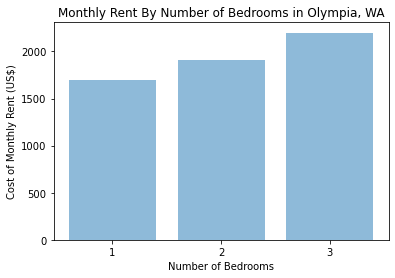

In [26]:
M3 = M3[M3['Beds'] != "0"]
M3 = M3.reset_index()
M3.drop("index", axis = 1, inplace = True)
M3

M4 = M4[M4['Beds']!="0"]
M4 = M4.reset_index()
M4.drop("index", axis = 1, inplace = True)

M3["Zillow-Price"] = M3["Zillow-Price"].astype(float)
Means = M3.groupby(['Beds']).mean()["Zillow-Price"]

plt.bar(np.arange(3), Means, align = 'center', alpha = 0.5)
plt.xticks(np.arange(3), (1,2,3))
plt.ylabel("Cost of Monthly Rent (US$)")
plt.xlabel("Number of Bedrooms")
plt.title("Monthly Rent By Number of Bedrooms in Olympia, WA")
plt.savefig(fname = "C:/Users/kevin/Downloads/avg.png" , format = "png")

In [27]:
M4

,Name,Address,City,State,ZIP,Beds,Apartments-Price,Zillow-Price,Latitude,Longitude,Phone
0,Smyth,3425 Polo Club Ln SE,Olympia,WA,98501,2,"$1,730",1726.0,46.999260,-122.847270,(360) 515-3840
1,Smyth,3425 Polo Club Ln SE,Olympia,WA,98501,3,"$1,730",2129.0,46.999260,-122.847270,(360) 515-3840
2,Breckenridge Apartments,2820 Tuscany Ln SW,Tumwater,WA,98512,NaN,"$1,470 - 1,800",NaN,NaN,NaN,(360) 515-4235
3,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,1,"$1,577 - 2,385",1577.0,46.994087,-122.734215,(360) 634-0417
4,Imber at Union Mills,8519 Oya Ln SE,Olympia,WA,98513,2,"$1,577 - 2,385",1869.0,46.994087,-122.734215,(360) 634-0417
5,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,1,"$1,423 - 2,401",1423.0,47.017014,-122.917534,(360) 634-0999
6,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,2,"$1,423 - 2,401",1582.0,47.017014,-122.917534,(360) 634-0999
7,Montair at Somerset Hill,1704 Barnes Blvd SW,Tumwater,WA,98512,3,"$1,423 - 2,401",1968.0,47.017014,-122.917534,(360) 634-0999
8,Callen,1404 Brittany Ln NE,Lacey,WA,98516,1,"$1,700 - 1,815",1763.0,47.059850,-122.757470,(360) 995-1232
9,Callen,1404 Brittany Ln NE,Lacey,WA,98516,2,"$1,700 - 1,815",1837.0,47.059850,-122.757470,(360) 995-1232


In [30]:
Map = folium.Map(location = [47.046320, -122.883000], zoom_start = 11) #This is the address of my workplace

cols = ['Name', 'Beds', 'Zillow-Price', 'Latitude', 'Longitude']
for Name, Beds, ZillowPrice, Latitude, Longitude in M3[cols].itertuples(index = False):
    popup = folium.Popup(Name + ", Beds: " + str(Beds) + ", Price: " + str(ZillowPrice), parse_html = True, max_width = 200)
    circle = folium.Circle(location = [float(Latitude), float(Longitude)], color = "blue", radius = 25, popup = popup)
    Map.add_child(circle)
    
fig = folium.Figure(width = 800, height = 600)
fig.add_child(Map)

# for i, row in M3.iterrows():
#     iframe = folium.IFrame(row["Name"])
#     popup = folium.Popup(iframe, min_width = 200, max_width = 200)
#     folium.Marker(location = [row["Latitude"], row["Longitude"]], popup = popup, c=row['State']).add_to(Map)

#Map.save("OlympiaLocs.html")

In [28]:
Means

Beds
1    1699.9
2    1907.0
3    2199.0
Name: Zillow-Price, dtype: float64